In [32]:
from dotenv import load_dotenv
load_dotenv()

True

In [33]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI()

In [34]:
from langchain_community.tools.tavily_search import TavilySearchResults

web_search_tool = TavilySearchResults(max_results=2)

In [35]:
from langchain_community.document_loaders import PyPDFLoader, Docx2txtLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
from typing import List
from langchain_core.documents import Document
import os

In [36]:
def load_documents(folder_path: str) -> List[Document]:
     documents = []
     for filename in os.listdir(folder_path):
         file_path = os.path.join(folder_path, filename)
         if filename.endswith('.pdf'):
             print(filename)
             loader = PyPDFLoader(file_path)
         elif filename.endswith('.docx'):
             loader = Docx2txtLoader(file_path)
         else:
             print(f"Unsupported file type: {filename}")
             continue
         documents.extend(loader.load())
     return documents

folder_path = "./docs"
documents = load_documents(folder_path)
print(f"Loaded {len(documents)} documents from the folder.")


TheFutureofAI.pdf
Loaded 9 documents from the folder.


In [37]:
text_splitter = RecursiveCharacterTextSplitter(
     chunk_size=1000,
     chunk_overlap=200,
     length_function=len
 )

splits = text_splitter.split_documents(documents)
print(f"Split the documents into {len(splits)} chunks.")

Split the documents into 30 chunks.


In [38]:
from langchain_community.embeddings.sentence_transformer import SentenceTransformerEmbeddings

embedding_function = SentenceTransformerEmbeddings(model_name="all-MiniLM-L6-v2")

In [39]:
from langchain_chroma import Chroma

collection_name = "my_collection"
vectorstore = Chroma.from_documents(
    collection_name=collection_name,
    documents=splits,
    embedding=embedding_function,
    persist_directory="./chroma_db"
)

In [40]:
from langchain.tools import tool
from pydantic import BaseModel

class RagToolSchema(BaseModel):
    question: str

@tool(args_schema=RagToolSchema)
def retriever_tool(question):
    """Tool to Retrieve Semantically Similar documents to answer User Questions related to Future of AI."""
    print("INSIDE RETRIEVER NODE")
    retriever = vectorstore.as_retriever(search_kwargs={"k": 2})
    retriever_result = retriever.invoke(question)
    return "\n\n".join(doc.page_content for doc in retriever_result)


In [41]:
from langchain_community.utilities import SQLDatabase

db = SQLDatabase.from_uri("sqlite:///Chinook.db")

In [42]:
import re

def clean_sql_query(text: str) -> str:
    """
    Clean SQL query by removing code block syntax, various SQL tags, backticks,
    prefixes, and unnecessary whitespace while preserving the core SQL query.

    Args:
        text (str): Raw SQL query text that may contain code blocks, tags, and backticks

    Returns:
        str: Cleaned SQL query
    """
    # Step 1: Remove code block syntax and any SQL-related tags
    # This handles variations like ```sql, ```SQL, ```SQLQuery, etc.
    block_pattern = r"```(?:sql|SQL|SQLQuery|mysql|postgresql)?\s*(.*?)\s*```"
    text = re.sub(block_pattern, r"\1", text, flags=re.DOTALL)

    # Step 2: Handle "SQLQuery:" prefix and similar variations
    # This will match patterns like "SQLQuery:", "SQL Query:", "MySQL:", etc.
    prefix_pattern = r"^(?:SQL\s*Query|SQLQuery|MySQL|PostgreSQL|SQL)\s*:\s*"
    text = re.sub(prefix_pattern, "", text, flags=re.IGNORECASE)

    # Step 3: Extract the first SQL statement if there's random text after it
    # Look for a complete SQL statement ending with semicolon
    sql_statement_pattern = r"(SELECT.*?;)"
    sql_match = re.search(sql_statement_pattern, text, flags=re.IGNORECASE | re.DOTALL)
    if sql_match:
        text = sql_match.group(1)

    # Step 4: Remove backticks around identifiers
    text = re.sub(r'`([^`]*)`', r'\1', text)

    # Step 5: Normalize whitespace
    # Replace multiple spaces with single space
    text = re.sub(r'\s+', ' ', text)

    # Step 6: Preserve newlines for main SQL keywords to maintain readability
    keywords = ['SELECT', 'FROM', 'WHERE', 'GROUP BY', 'HAVING', 'ORDER BY',
               'LIMIT', 'JOIN', 'LEFT JOIN', 'RIGHT JOIN', 'INNER JOIN',
               'OUTER JOIN', 'UNION', 'VALUES', 'INSERT', 'UPDATE', 'DELETE']

    # Case-insensitive replacement for keywords
    pattern = '|'.join(r'\b{}\b'.format(k) for k in keywords)
    text = re.sub(f'({pattern})', r'\n\1', text, flags=re.IGNORECASE)

    # Step 7: Final cleanup
    # Remove leading/trailing whitespace and extra newlines
    text = text.strip()
    text = re.sub(r'\n\s*\n', '\n', text)

    return text


In [43]:
from langchain.chains import create_sql_query_chain
from langchain_community.tools.sql_database.tool import QuerySQLDataBaseTool
from operator import itemgetter
import re
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import PromptTemplate
from langchain_core.runnables import RunnablePassthrough, RunnableLambda

In [44]:
class SQLToolSchema(BaseModel):
    question: str

@tool(args_schema=SQLToolSchema)
def nl2sql_tool(question):
    """Tool to Generate and Execute SQL Query to answer User Questions related to chinook DB"""
    print("INSIDE NL2SQL TOOL")
    execute_query = QuerySQLDataBaseTool(db=db)
    write_query = create_sql_query_chain(llm, db)

    chain = (
        RunnablePassthrough.assign(query=write_query | RunnableLambda(clean_sql_query)).assign(
            result=itemgetter("query") | execute_query
        )
    )

    response = chain.invoke({"question": question})
    return response['result']

### Supervisor Agent

In [45]:
from typing import Literal
from typing_extensions import TypedDict
from langgraph.graph import MessagesState, START, END
from langgraph.types import Command
from langchain_core.messages import HumanMessage, AIMessage
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import create_react_agent

In [46]:
from typing import Callable, Literal, Optional, Sequence, Type, TypeVar, Union, cast
from langchain_core.language_models import BaseChatModel, LanguageModelLike
from langchain_core.messages import AIMessage, BaseMessage, SystemMessage, ToolMessage
from langchain_core.runnables import (
    Runnable,
    RunnableBinding,
    RunnableConfig,
)
from langchain_core.tools import BaseTool
from typing_extensions import Annotated, TypedDict
from langgraph._api.deprecation import deprecated_parameter
from langgraph.errors import ErrorCode, create_error_message
from langgraph.graph import StateGraph
from langgraph.graph.graph import CompiledGraph
from langgraph.graph.message import add_messages
from langgraph.managed import IsLastStep, RemainingSteps
# from langgraph.prebuilt.tool_executor import ToolExecutor
from langgraph.prebuilt.tool_node import ToolNode, tools_condition
from langgraph.store.base import BaseStore
from langgraph.types import Checkpointer
from langgraph.utils.runnable import RunnableCallable

In [47]:
# Define available agents
members = ["web_researcher", "rag", "nl2sql"]
# Add FINISH as an option for task completion
options = members + ["FINISH"]

In [48]:
# Create system prompt for supervisor
system_prompt = (
    "You are a supervisor tasked with managing a conversation between the"
    f" following workers: {members}. Given the following user request,"
    " respond with the worker to act next. Each worker will perform a"
    " task and respond with their results and status. When finished,"
    " respond with FINISH."
)

In [49]:
# Define router type for structured output
class Router(TypedDict):
    """Worker to route to next. If no workers needed, route to FINISH."""
    next: Literal["web_researcher", "rag", "nl2sql", "FINISH"]

In [50]:
# Create supervisor node function
def supervisor_node(state: MessagesState) -> Command[Literal["web_researcher", "rag", "nl2sql", "__end__"]]:
    messages = [
        {"role": "system", "content": system_prompt},
    ] + state["messages"]
    response = llm.with_structured_output(Router).invoke(messages)
    goto = response["next"]
    print(f"Next Worker: {goto}")
    if goto == "FINISH":
        goto = END
    return Command(goto=goto)

In [51]:
class AgentState(TypedDict):
    """The state of the agent."""
    messages: Annotated[Sequence[BaseMessage], add_messages]

def create_agent(llm, tools):
    llm_with_tools = llm.bind_tools(tools)
    def chatbot(state: AgentState):
        return {"messages": [llm_with_tools.invoke(state["messages"])]}

    graph_builder = StateGraph(AgentState)
    graph_builder.add_node("agent", chatbot)

    tool_node = ToolNode(tools=tools)
    graph_builder.add_node("tools", tool_node)

    graph_builder.add_conditional_edges(
        "agent",
        tools_condition,
    )
    graph_builder.add_edge("tools", "agent")
    graph_builder.set_entry_point("agent")
    return graph_builder.compile()


In [52]:
websearch_agent = create_agent(llm, [web_search_tool])

def web_research_node(state: MessagesState) -> Command[Literal["supervisor"]]:
    result = websearch_agent.invoke(state)
    return Command(
        update={
            "messages": [
                HumanMessage(content=result["messages"][-1].content, name="web_researcher")
            ]
        },
        goto="supervisor",
    )

In [53]:
rag_agent = create_agent(llm, [retriever_tool])

def rag_node(state: MessagesState) -> Command[Literal["supervisor"]]:
    result = rag_agent.invoke(state)
    return Command(
        update={
            "messages": [
                HumanMessage(content=result["messages"][-1].content, name="rag")
            ]
        },
        goto="supervisor",
    )

In [54]:
nl2sql_agent = create_agent(llm, [nl2sql_tool])

def nl2sql_node(state: MessagesState) -> Command[Literal["supervisor"]]:
    result = nl2sql_agent.invoke(state)
    return Command(
        update={
            "messages": [
                HumanMessage(content=result["messages"][-1].content, name="nl2sql")
            ]
        },
        goto="supervisor",
    )

In [58]:
for evt in nl2sql_agent.stream(
    {"messages": [("user", "Find the top 3 albums")]}, 
):
    print(evt)

{'agent': {'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_80Ufa4ufrwaYtHVyonZLuaAH', 'function': {'arguments': '{"question":"Find the top 3 albums"}', 'name': 'nl2sql_tool'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 22, 'prompt_tokens': 63, 'total_tokens': 85, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'id': 'chatcmpl-BJT1z4v6WhLcbiKZ9KT0S38gPozrU', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-070c554d-e7a7-4589-b964-964fba79f7a4-0', tool_calls=[{'name': 'nl2sql_tool', 'args': {'question': 'Find the top 3 albums'}, 'id': 'call_80Ufa4ufrwaYtHVyonZLuaAH', 'type': 'tool_call'}], usage_metadata={'input_tokens': 63, 'output_tokens': 22, 'total_tokens': 85, 'input_tok

In [55]:
builder = StateGraph(MessagesState)
builder.add_edge(START, "supervisor")
builder.add_node("supervisor", supervisor_node)
builder.add_node("web_researcher", web_research_node)
builder.add_node("rag", rag_node)
builder.add_node("nl2sql", nl2sql_node)
graph = builder.compile()

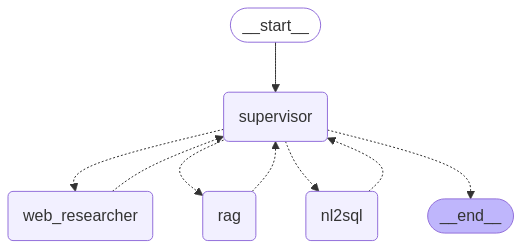

In [56]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # You can put your exception handling code here
    pass


In [57]:
# Example: Complex Query Using Multiple Agents
input_question = "Find the top 3 albums"
for s in graph.stream(
    {"messages": [("user", input_question)]}, 
    subgraphs=True
):
    print(s)
    print("----")


/Users/mehulmathur/AI Projects/Langgraph MultiAgent Basic/langgraph_multiagent/lib/python3.13/site-packages/langchain_openai/chat_models/base.py:1637: UserWarning: Cannot use method='json_schema' with model gpt-3.5-turbo since it doesn't support OpenAI's Structured Output API. You can see supported models here: https://platform.openai.com/docs/guides/structured-outputs#supported-models. To fix this warning, set `method='function_calling'. Overriding to method='function_calling'.
  warnings.warn(


Next Worker: web_researcher
((), {'supervisor': None})
----
(('web_researcher:7e192103-281e-0944-0755-4db07e244777',), {'agent': {'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_D9EnR2fOzSHMA6FUhENDkx04', 'function': {'arguments': '{"query":"top 3 albums"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 22, 'prompt_tokens': 87, 'total_tokens': 109, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'id': 'chatcmpl-BJT0gasGMH5aCLvXLy7igad2Jl4Li', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-a1a9e3c0-9f43-48ff-a17c-654265c5c204-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'top 3 albums'}, 'id': 'call_D9EnR2fOzSH

/Users/mehulmathur/AI Projects/Langgraph MultiAgent Basic/langgraph_multiagent/lib/python3.13/site-packages/langchain_openai/chat_models/base.py:1637: UserWarning: Cannot use method='json_schema' with model gpt-3.5-turbo since it doesn't support OpenAI's Structured Output API. You can see supported models here: https://platform.openai.com/docs/guides/structured-outputs#supported-models. To fix this warning, set `method='function_calling'. Overriding to method='function_calling'.
  warnings.warn(


Next Worker: rag
((), {'supervisor': None})
----
INSIDE RETRIEVER NODE(('rag:ebfe9148-d951-56a6-8870-6ffc4094b2be',), {'agent': {'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_tYNJFBZipeGRtNEsKBZqogWB', 'function': {'arguments': '{"question": "What are the top 3 albums of all time?"}', 'name': 'retriever_tool'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 42, 'prompt_tokens': 233, 'total_tokens': 275, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'id': 'chatcmpl-BJT0l8TwtsIlKvzTeYE4opKYmSSg6', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-066911a5-7ef7-4a7b-9e2c-1280764cb218-0', tool_calls=[{'name': 'retriever_tool', 'args': {'question': 'What are the top 3 albums of a

/Users/mehulmathur/AI Projects/Langgraph MultiAgent Basic/langgraph_multiagent/lib/python3.13/site-packages/langchain_openai/chat_models/base.py:1637: UserWarning: Cannot use method='json_schema' with model gpt-3.5-turbo since it doesn't support OpenAI's Structured Output API. You can see supported models here: https://platform.openai.com/docs/guides/structured-outputs#supported-models. To fix this warning, set `method='function_calling'. Overriding to method='function_calling'.
  warnings.warn(


Next Worker: nl2sql
((), {'supervisor': None})
----
(('nl2sql:027c88a7-7055-f603-b7a6-af0f31cae086',), {'agent': {'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_NiHBxsXu5iHSLRujY8nzdeJS', 'function': {'arguments': '{"question": "What are the top 3 albums in the chinook database?"}', 'name': 'nl2sql_tool'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 44, 'prompt_tokens': 317, 'total_tokens': 361, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'id': 'chatcmpl-BJT0qLqx3FLYpXnk2AE4pLKFMtjqE', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-07157ec4-b903-44c7-b519-41f7c05946fa-0', tool_calls=[{'name': 'nl2sql_tool', 'args': {'question': 'What are the top 3 albums in the chinoo

/var/folders/f3/ztvztwvx319gkrwkcgfkyk180000gn/T/ipykernel_16701/3109450319.py:8: LangChainDeprecationWarning: The class `QuerySQLDataBaseTool` was deprecated in LangChain 0.3.12 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-community package and should be used instead. To use it run `pip install -U :class:`~langchain-community` and import as `from :class:`~langchain_community.tools import QuerySQLDatabaseTool``.
  execute_query = QuerySQLDataBaseTool(db=db)


(('nl2sql:027c88a7-7055-f603-b7a6-af0f31cae086',), {'tools': {'messages': [ToolMessage(content='[(347, \'Koyaanisqatsi (Soundtrack from the Motion Picture)\', 275), (346, \'Mozart: Chamber Music\', 274), (345, "Monteverdi: L\'Orfeo", 273)]', name='nl2sql_tool', id='1df3ba32-7190-49c0-a540-a2f121b07afe', tool_call_id='call_NiHBxsXu5iHSLRujY8nzdeJS')]}})
----
(('nl2sql:027c88a7-7055-f603-b7a6-af0f31cae086',), {'agent': {'messages': [AIMessage(content="The top 3 albums in the Chinook database are as follows:\n1. Koyaanisqatsi (Soundtrack from the Motion Picture)\n2. Mozart: Chamber Music\n3. Monteverdi: L'Orfeo\n\nThese are the top 3 albums based on the data in the Chinook database.", additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 69, 'prompt_tokens': 408, 'total_tokens': 477, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'aud

/Users/mehulmathur/AI Projects/Langgraph MultiAgent Basic/langgraph_multiagent/lib/python3.13/site-packages/langchain_openai/chat_models/base.py:1637: UserWarning: Cannot use method='json_schema' with model gpt-3.5-turbo since it doesn't support OpenAI's Structured Output API. You can see supported models here: https://platform.openai.com/docs/guides/structured-outputs#supported-models. To fix this warning, set `method='function_calling'. Overriding to method='function_calling'.
  warnings.warn(


Next Worker: FINISH
((), {'supervisor': None})
----
